# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
db_filename = 'DisasterResponse.db'
db_tablename = 'messages'

In [3]:
labels = [ 
 'related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'child_alone',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report'
]

In [4]:
# load data from database
engine = create_engine(f'sqlite:///{db_filename}')
df = pd.read_sql_table(db_tablename, engine)
X = df.message
Y = df[labels]

### 2. Write a tokenization function to process your text data

In [118]:
import re

url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
url_placeholder = '_URL_'

punctuation_tokenizer = RegexpTokenizer(r'\w+')

lemmatizer = WordNetLemmatizer()

def create_placeholder_for_urls(text):
    return re.sub(url_regex, url_placeholder, text)

def remove_all_punctuation(text):
    return punctuation_tokenizer.tokenize(text)

def tokenize(text):
    lower_text = text.lower().strip()
    placeholder_text = create_placeholder_for_urls(lower_text)
    tokens = remove_all_punctuation(placeholder_text) # word_tokenize(placeholder_text)
    return list(map(lemmatizer.lemmatize, tokens))

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [8]:
import nltk

nltk.download('twitter_samples')

from nltk.tag import pos_tag
from nltk.corpus import twitter_samples

tweet_tokens = twitter_samples.tokenized('positive_tweets.json')

pos_tag(tweet_tokens[0])

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/bruno/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


[('#FollowFriday', 'JJ'),
 ('@France_Inte', 'NNP'),
 ('@PKuchly57', 'NNP'),
 ('@Milipol_Paris', 'NNP'),
 ('for', 'IN'),
 ('being', 'VBG'),
 ('top', 'JJ'),
 ('engaged', 'VBN'),
 ('members', 'NNS'),
 ('in', 'IN'),
 ('my', 'PRP$'),
 ('community', 'NN'),
 ('this', 'DT'),
 ('week', 'NN'),
 (':)', 'NN')]

In [104]:
import spacy

en_us_model = spacy.load("en_core_web_sm")

question_tokens = [ 'qual', 'onde', 'quando', 'quem', 'como', 'porque', 'por que', 'what', 'where', 'when', 'who', 'whom', 'how', 'why' ]

from nltk.tokenize import sent_tokenize

def is_question(text):
    lower_text = en_us_model(text.lower())
    return lower_text[0].text in question_tokens or is_yes_or_no_question(lower_text)

def is_yes_or_no_question(text_model):
    return text_model[0].dep_ == 'aux'

In [102]:

tx = 'How do I go about this?'

def check_any_sentence_is_question(text):
    return any(filter(is_question, sent_tokenize(text.lower())))


check_any_sentence_is_question(tx)

7.52 ms ± 44.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [107]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import sent_tokenize

class QuestionExtractor(BaseEstimator, TransformerMixin):

    def question_extractor(self, text):
        
        return check_any_sentence_is_question(text)

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(pd.Series(X).apply(self.question_extractor))

In [106]:
check_any_sentence_is_question('he died in the crash of the plane that dropped in tom‚àö¬© u.u')

False

In [94]:
[ message for message in X_train if check_any_sentence_is_question(message) ]

["i'm a mecanic i worked since 7 to 8 years and i have licence type B i think we can considerate my case. may god bless you, thanks. ",
 'How are the activities of class, especially in Petit Goave? ',
 'Where they can go? what walk they have to do? ',
 'How do I find help to find a housing centre?',
 'Where can we can training for a Job? ',
 'A criminal gang is actively looking for me. They carry with my picture. How can you help me. Mt life is in danger now. .. ',
 'How much monney for issue a passport now. ',
 'what you are saying is really important. for me it is hunger that is killing me and you never speak of this',
 'Where are the people of Medecins sans Frontieres? ',
 'The Voice of America. Please pass the message along for us. We live in Gressier, 24th section ( Ti Boukan ). We are dying of hunger. What we had is finished. PLease pass the message along for us.',
 'Will there be a tsunami in Haiti..thank you ',
 'Good evening. I am in the NW department. I would like to work wit

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 42)

In [70]:
pipeline = Pipeline([
        ('vectorizer', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultiOutputClassifier(RandomForestClassifier(n_estimators = 10)))
])

In [71]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function toke...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [72]:
y_pred = pipeline.predict(X_test)

In [19]:
def display_results(column_name, column_index, y_test, y_pred):
    
    curr_y_test = y_test[[column_name]]
    curr_y_pred = y_pred[:, column_index]
    
    labels = [0,1] # np.unique(curr_y_test)
    confusion_mat = confusion_matrix(curr_y_test, curr_y_pred, labels=labels)
    accuracy = (curr_y_test[column_name] == curr_y_pred).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)

In [288]:
for idx, name in enumerate(list(y_test.columns)):
    
    print(f'Category: {name} at index {idx}')
    
    display_results(name, idx, y_test, y_pred)
    
    print('\n\n')

Category: related at index 0
Labels: [0, 1]
Confusion Matrix:
 [[ 824  715]
 [ 533 4474]]
Accuracy: 0.8093492208982584



Category: request at index 1
Labels: [0, 1]
Confusion Matrix:
 [[5189  234]
 [ 488  635]]
Accuracy: 0.8897036358081271



Category: offer at index 2
Labels: [0, 1]
Confusion Matrix:
 [[6512    0]
 [  33    1]]
Accuracy: 0.9949587534372135



Category: aid_related at index 3
Labels: [0, 1]
Confusion Matrix:
 [[3060  724]
 [ 925 1837]]
Accuracy: 0.7480904369080354



Category: medical_help at index 4
Labels: [0, 1]
Confusion Matrix:
 [[5892  124]
 [ 361  169]]
Accuracy: 0.9259089520317751



Category: medical_products at index 5
Labels: [0, 1]
Confusion Matrix:
 [[6151   74]
 [ 223   98]]
Accuracy: 0.9546287809349221



Category: search_and_rescue at index 6
Labels: [0, 1]
Confusion Matrix:
 [[6351   28]
 [ 128   39]]
Accuracy: 0.9761686526122824



Category: security at index 7
Labels: [0, 1]
Confusion Matrix:
 [[6410   12]
 [ 119    5]]
Accuracy: 0.9799877787962115


In [118]:
display_results(y_test, y_pred)

Labels: [0, 1]
Confusion Matrix:
 [[5392   87]
 [ 664  403]]
Accuracy: 0.8852734494347694


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [37]:
# !pip install spacy
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0MB 371kB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-cp37-none-any.whl size=12011740 sha256=040feb54600fa7b091be5adf18cd059f30b00d622659129130805c2328c9bd93
  Stored in directory: /tmp/pip-ephem-wheel-cache-h2ra2hua/wheels/6a/47/fb/6b5a0b8906d8e8779246c67d4658fd8a544d4a03a75520197a
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [74]:
print(classification_report(y_test.values, y_pred, target_names=labels, output_dict = False))

                        precision    recall  f1-score   support

               related       0.85      0.91      0.88      5007
               request       0.81      0.42      0.56      1123
                 offer       0.00      0.00      0.00        34
           aid_related       0.76      0.58      0.66      2762
          medical_help       0.66      0.10      0.17       530
      medical_products       0.76      0.10      0.17       321
     search_and_rescue       0.65      0.13      0.22       167
              security       0.00      0.00      0.00       124
              military       0.57      0.05      0.09       233
           child_alone       0.00      0.00      0.00         0
                 water       0.83      0.44      0.57       432
                  food       0.85      0.57      0.68       742
               shelter       0.78      0.29      0.42       576
              clothing       0.90      0.09      0.17        97
                 money       0.57      

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [140]:
report = classification_report(y_test.values, y_pred, target_names=labels, output_dict = True)

In [141]:
def map_with_key(key):
    result = report.get(key)
    result['category'] = key
    return result

In [142]:
df_metrics = pd.DataFrame(list(map(map_with_key, labels)))
df_metrics.head(20)

,precision,recall,f1-score,support,category
0,0.842189,0.952866,0.894115,5007,related
1,0.831150,0.508459,0.630939,1123,request
2,0.000000,0.000000,0.000000,34,offer
3,0.783290,0.651702,0.711462,2762,aid_related
4,0.688525,0.158491,0.257669,530,medical_help
5,0.706667,0.165109,0.267677,321,medical_products
6,0.937500,0.089820,0.163934,167,search_and_rescue
7,0.000000,0.000000,0.000000,124,security
8,0.729730,0.115880,0.200000,233,military
9,0.799180,0.451389,0.576923,432,water


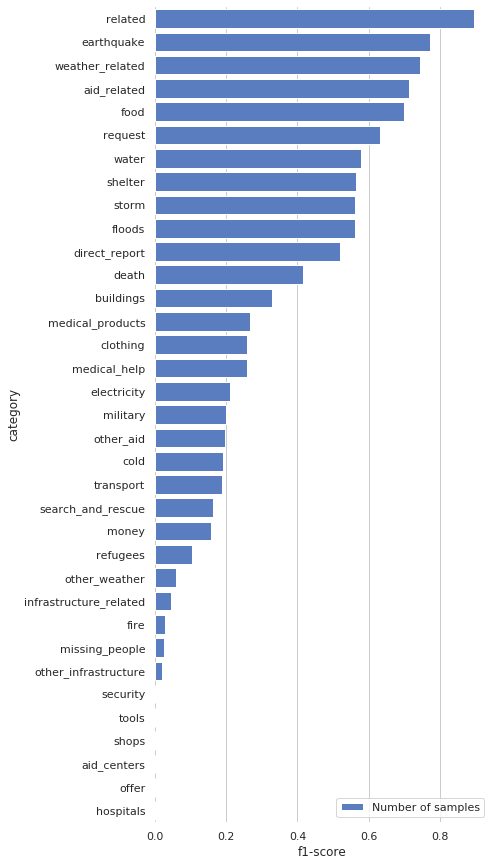

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
 
f, ax = plt.subplots(figsize=(6, 15))
 
sns.set_color_codes("muted")
sns.barplot(x="f1-score", y="category", data=df_metrics.sort_values(by = 'f1-score', ascending = False), label="Number of samples", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)

sns.despine(left=True, bottom=True)

#### Testing with stop words removal

In [108]:
import nltk

from nltk.corpus import stopwords

from spacy.lang.en.stop_words import STOP_WORDS

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/bruno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [119]:
import re

url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
url_placeholder = '_URL_'

lemmatizer = WordNetLemmatizer()

def create_placeholder_for_urls(text):
    return re.sub(url_regex, url_placeholder, text)

def tokenize(text):
    lower_text = text.lower().strip()
    placeholder_text = create_placeholder_for_urls(lower_text)
    tokens = remove_all_punctuation(placeholder_text) # word_tokenize(placeholder_text)
    only_relevant_words = words_without_stopwords(tokens)
    return list(map(lemmatizer.lemmatize, only_relevant_words))

In [110]:
nltk_stop_words = stopwords.words('english')
spacy_stop_words = list(STOP_WORDS)

all_stop_words = set(nltk_stop_words + spacy_stop_words)

def words_without_stopwords(words):
    return list(filter(lambda w: w not in all_stop_words, words))

In [48]:
pipeline = Pipeline([
        ('vectorizer', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultiOutputClassifier(RandomForestClassifier()))
])

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, Y.drop(['child_alone'], axis = 1), random_state = 42)

In [137]:
pipeline.fit(X_train.values, y_train.values)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  low

In [138]:
y_pred = pipeline.predict(X_test)

In [123]:
labels.pop(labels.index('child_alone'))

'child_alone'

In [298]:
print(classification_report(y_test, y_pred, target_names=labels, output_dict = False))

                        precision    recall  f1-score   support

               related       0.86      0.89      0.88      5007
               request       0.73      0.57      0.64      1123
                 offer       1.00      0.03      0.06        34
           aid_related       0.72      0.67      0.69      2762
          medical_help       0.58      0.32      0.41       530
      medical_products       0.57      0.31      0.40       321
     search_and_rescue       0.58      0.23      0.33       167
              security       0.29      0.04      0.07       124
              military       0.66      0.29      0.40       233
                 water       0.76      0.54      0.63       432
                  food       0.81      0.64      0.72       742
               shelter       0.74      0.50      0.60       576
              clothing       0.83      0.30      0.44        97
                 money       0.59      0.23      0.33       160
        missing_people       0.70      

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [139]:
print(classification_report(y_test, y_pred, target_names=labels, output_dict = False))

                        precision    recall  f1-score   support

               related       0.84      0.95      0.89      5007
               request       0.83      0.51      0.63      1123
                 offer       0.00      0.00      0.00        34
           aid_related       0.78      0.65      0.71      2762
          medical_help       0.69      0.16      0.26       530
      medical_products       0.71      0.17      0.27       321
     search_and_rescue       0.94      0.09      0.16       167
              security       0.00      0.00      0.00       124
              military       0.73      0.12      0.20       233
                 water       0.80      0.45      0.58       432
                  food       0.86      0.59      0.70       742
               shelter       0.83      0.43      0.56       576
              clothing       0.79      0.15      0.26        97
                 money       0.82      0.09      0.16       160
        missing_people       1.00      

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [104]:
print(classification_report(y_test, y_pred, target_names=labels, output_dict = False))

                        precision    recall  f1-score   support

               related       0.85      0.91      0.88      5007
               request       0.78      0.43      0.56      1123
                 offer       0.00      0.00      0.00        34
           aid_related       0.75      0.60      0.67      2762
          medical_help       0.68      0.10      0.17       530
      medical_products       0.69      0.06      0.11       321
     search_and_rescue       0.69      0.05      0.10       167
              security       0.20      0.01      0.02       124
              military       0.67      0.05      0.10       233
           child_alone       0.00      0.00      0.00         0
                 water       0.85      0.41      0.55       432
                  food       0.88      0.53      0.66       742
               shelter       0.79      0.39      0.52       576
              clothing       0.83      0.15      0.26        97
                 money       0.78      

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### 6. Improve your model
Use grid search to find better parameters. 

In [158]:
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import PassiveAggressiveClassifier

model = LogisticRegression(multi_class = 'ovr', verbose = 1, solver = 'liblinear', random_state = 42, penalty = 'l2', max_iter = 1000) # PassiveAggressiveClassifier() # MultinomialNB(alpha=0.05) # 

In [114]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import sent_tokenize

class NumericDigitExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
 
        sentence_list = sent_tokenize(text)
        
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            
            return False if len(pos_tags) == 0 else next(filter(lambda c: c[1] == 'CD', pos_tags), None) is not None

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)
    

In [248]:
re.search('//t\.co|@|#', 'Sandy #relief efforts in full swing @foodcoop @Park Slope Food Coop http : //t.co/XN3QwUct')

In [148]:
pipeline = Pipeline([
        ('features', FeatureUnion([
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),
            ('numeric_digit', NumericDigitExtractor()),
            ('question', QuestionExtractor())
        ])),
    
        ('classifier', MultiOutputClassifier(model)) 
    ])

In [174]:
parameters = {
    'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
    'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
    'features__text_pipeline__vect__max_features': (None, 5000, 10000),
    #'features__text_pipeline__tfidf__use_idf': (True, False),
    #'features__text_pipeline__tfidf__norm': ('l1', 'l2'),
    #'classifier__estimator__n_estimators': [50, 100, 200],
    'classifier__estimator__C': [5, 10],
    'classifier__estimator__penalty' : ['l1', 'l2']
}

In [188]:
cv = GridSearchCV(pipeline, param_grid = parameters, n_jobs = -1, verbose = 10)

In [190]:
from sklearn.utils import parallel_backend as sk_pb
from joblib import parallel_backend as jl_pb

for lib, ctx, back in [("joblib", jl_pb, "multiprocessing"),
                       ("sklearn", sk_pb, "multiprocessing"),
                       ("joblib", jl_pb, "loky"),
                       ("sklearn", sk_pb, "loky")]:
    with ctx(backend=back):
        status = "OK"
        try:
            cv.fit(X_train, y_train)
        except Exception as e:
            status = f"{e}"
            # raise
    # end with

    print(f"backend {lib}-{back}: {status}")

[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1) 
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1) 
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1) 
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2) 
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_featur

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 16 concurrent workers.


[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1) 
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1) 
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2) 
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2) 
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_featur

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.260, total=12.2min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLine

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), score=0.258, total=13.1min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLine

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 13.2min


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.265, total=13.3min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLin

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), score=0.244, total=18.9min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2) 


/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.269, total=12.8min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2) 


/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.265, total=14.3min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLin

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 30.5min


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.261, total=17.5min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLi

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.259, total=14.4min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLine

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.259, total=15.3min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLin

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.257, total=16.5min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLin

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 47.1min


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.265, total=16.7min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLin

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), score=0.258, total=14.6min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2) 


/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.264, total=14.7min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1) 


/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.261, total=16.7min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLine

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.268, total=16.6min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1) 


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 73.5min


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.259, total=15.2min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLine

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), score=0.283, total=14.1min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLine

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 94.4min


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), score=0.280, total=13.8min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLine

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.287, total=14.7min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLin

[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 114.0min


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), score=0.287, total=15.2min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLin

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.291, total=15.3min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLine

[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 131.9min


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.286, total=13.8min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLin

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), score=0.261, total=133.0min
[CV] classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLi

[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 148.1min


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.287, total=13.5min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLine

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.290, total=13.5min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1) 


/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=5, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.283, total=13.8min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLi

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.229, total=14.0min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLi

[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed: 171.6min


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.233, total=17.7min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLi

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.232, total=16.0min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibL

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.234, total=14.3min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2) 


/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), score=0.240, total=17.6min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2) 


/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.228, total=16.8min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][Lib

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.229, total=19.9min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][Lib

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.230, total=19.1min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1) 


/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.232, total=18.3min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1) 


[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 214.1min


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.233, total=17.8min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibL

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.234, total=18.2min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2) 


/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), score=0.237, total=88.5min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLin

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.228, total=21.0min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLin

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), score=0.237, total=107.7min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][Lib

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.233, total=18.8min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLi

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), score=0.224, total=149.2min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibL

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.233, total=17.5min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLi

[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed: 312.2min


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l1, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.234, total=18.4min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLi

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), score=0.281, total=19.6min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLi

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 354.8min


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.279, total=18.1min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibL

[CV] classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.277, total=15.4min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=1

[CV] classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.273, total=14.5min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=500

[CV] classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2) 
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), score=0.277, total=14.1min
[CV] classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=1000

[Parallel(n_jobs=-1)]: Done 207 out of 216 | elapsed: 415.5min remaining: 18.1min


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV]  classifier__estimator__C=10, classifier__estimator__penalty=l2, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), score=0.280, total=12.7min
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 501.7min finished
Process ForkPoolWorker-117:
Process ForkPoolWorker-116:
Process ForkPoolWorker-111:
Process ForkPoolWorker-112:
Process ForkPoolWorker-113:
Process ForkPoolWorker-107:
Process ForkPoolWorker-115:
Process ForkPoolWorker-108:
Process ForkPoolWorker-122:
Process ForkPoolWorker-120:
Process ForkPoolWorker-110:
Process ForkPoolWorker-119:
Process ForkPoolWorker-118:
Process ForkPoolWorker-114:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-121:
Traceback (most recent call last):
  File "/home/bruno/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bruno/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most 

  File "/home/bruno/anaconda3/lib/python3.7/site-packages/joblib/pool.py", line 147, in get
    racquire()
  File "/home/bruno/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt


KeyboardInterrupt: 

In [191]:
cv

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('text_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('vect',
                                                                                         CountVectorizer(analyzer='word',
                                                                                                         binary=False,
                                                                                                         decode_error='strict',
                                                                                                         dtype=<class 'numpy.int64'

In [187]:
%env LOKY_PICKLER='cloudpickle' 
import multiprocessing

import importlib

importlib.reload(multiprocessing).set_start_method('forkserver')

cv.fit(X_train, y_train)

env: LOKY_PICKLER='cloudpickle'


RuntimeError: context has already been set

In [192]:
cv.best_params_

{'classifier__estimator__C': 5,
 'classifier__estimator__penalty': 'l2',
 'features__text_pipeline__vect__max_df': 0.5,
 'features__text_pipeline__vect__max_features': 5000,
 'features__text_pipeline__vect__ngram_range': (1, 2)}

In [193]:
cv.best_estimator_

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  low

In [195]:
cv.best_estimator_.fit(X_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  low

In [196]:
y_pred = cv.best_estimator_.predict(X_test) 

In [197]:
print(classification_report(y_test.values, y_pred, target_names=labels, output_dict = False))

                        precision    recall  f1-score   support

               related       0.86      0.91      0.89      5007
               request       0.81      0.56      0.66      1123
                 offer       0.00      0.00      0.00        34
           aid_related       0.76      0.66      0.71      2762
          medical_help       0.67      0.28      0.40       530
      medical_products       0.65      0.29      0.40       321
     search_and_rescue       0.75      0.14      0.24       167
              security       0.50      0.03      0.06       124
              military       0.67      0.25      0.36       233
                 water       0.79      0.56      0.66       432
                  food       0.85      0.67      0.75       742
               shelter       0.80      0.50      0.62       576
              clothing       0.76      0.30      0.43        97
                 money       0.63      0.17      0.27       160
        missing_people       0.90      

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


#### Testing with translated dataset

In [16]:
pipeline = Pipeline([
        ('vectorizer', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultiOutputClassifier(RandomForestClassifier(n_estimators = 10)))
])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [18]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function toke...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [19]:
y_pred = pipeline.predict(X_test)

In [20]:
print(classification_report(y_test.values, y_pred, target_names=labels, output_dict = False))

                        precision    recall  f1-score   support

               related       0.82      0.94      0.87      5003
               request       0.82      0.37      0.51      1114
                 offer       0.00      0.00      0.00        32
           aid_related       0.73      0.54      0.62      2691
          medical_help       0.61      0.07      0.13       538
      medical_products       0.79      0.07      0.13       331
     search_and_rescue       0.67      0.01      0.02       180
              security       0.00      0.00      0.00       119
              military       0.65      0.06      0.11       212
           child_alone       0.00      0.00      0.00         0
                 water       0.82      0.26      0.40       404
                  food       0.86      0.43      0.57       741
               shelter       0.83      0.26      0.40       596
              clothing       0.71      0.05      0.09       107
                 money       1.00      

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [ ]:
{
    'classifier__estimator__min_samples_split': 4,
    'classifier__estimator__n_estimators': 100,
    'features__text_pipeline__vect__max_df': 0.5,
    'features__text_pipeline__vect__max_features': 10000,
    'features__text_pipeline__vect__ngram_range': (1, 2)
}

In [22]:
pipeline = Pipeline([
        ('vectorizer', CountVectorizer(tokenizer=tokenize, max_df = 0.5, max_features = 10000, ngram_range = (1, 2))),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultiOutputClassifier(RandomForestClassifier(n_estimators = 100, min_samples_split = 4)))
])

In [23]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=10000, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tok...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [24]:
y_pred = pipeline.predict(X_test)

In [25]:
print(classification_report(y_test.values, y_pred, target_names=labels, output_dict = False))

                        precision    recall  f1-score   support

               related       0.82      0.97      0.89      5003
               request       0.84      0.49      0.62      1114
                 offer       0.00      0.00      0.00        32
           aid_related       0.76      0.66      0.71      2691
          medical_help       0.62      0.11      0.18       538
      medical_products       0.82      0.20      0.32       331
     search_and_rescue       0.73      0.12      0.21       180
              security       0.00      0.00      0.00       119
              military       0.65      0.06      0.11       212
           child_alone       0.00      0.00      0.00         0
                 water       0.81      0.57      0.67       404
                  food       0.83      0.71      0.76       741
               shelter       0.82      0.49      0.61       596
              clothing       0.81      0.23      0.36       107
                 money       1.00      

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.